In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

import pandas as pd

from scipy.stats import mannwhitneyu, wilcoxon

from access_science_shared import standardizer
from access_literature_data import medline

In [2]:
save_fig = True

In [3]:
ref_genes = standardizer.reference_genes(9606, 'orp')

In [4]:
df_m = medline.select_medline_records(
    columns_sql='''
        medline.pubmed_id,
        medline.pubdate_year''',
    taxon_id='all',
    kind='research',
)


In [5]:
gene2pubmed = medline.gene2pubmed(9606, paper_kind='research', ref_genes=ref_genes)

In [6]:
gene2pubmed = pd.merge(gene2pubmed, df_m)

In [7]:
gene2pubmed = gene2pubmed[gene2pubmed['pubdate_year'].isin(range(1980, 2016))]

In [8]:
t = pd.concat(
    [
    gene2pubmed[gene2pubmed['pubdate_year']<=2008]['gene_ncbi'].value_counts().to_frame('before'),
    gene2pubmed[gene2pubmed['pubdate_year'].isin(range(2009, 2016))]['gene_ncbi'].value_counts().to_frame('now'),    
        
    ], axis=1).reindex(ref_genes).fillna(0).rename_axis('gene_ncbi')
    

In [9]:
p = '/Users/tstoeger/Desktop/tcga_2008/41586_2008_BFnature07385_MOESM265_ESM.xls'

In [10]:
df = pd.read_excel(p, sheet_name='Table S6 - Mutation table')

In [11]:
tp = t.rank(pct=True) * 100

In [12]:
tp.loc[:, 'found'] = tp.index.isin(df['Entrez_Gene_Id'])

In [13]:
m = tp[tp['found']==True]

In [14]:
import matplotlib.pyplot as plt

In [15]:
m.shape

(223, 3)

In [16]:
m.sort_values('now', ascending=False).head()

,before,now,found
gene_ncbi,,,
7157,100.000000,100.000000,True
1956,99.968797,99.994800,True
2064,99.791981,99.937594,True
6774,99.667169,99.916792,True
3845,99.230329,99.911592,True


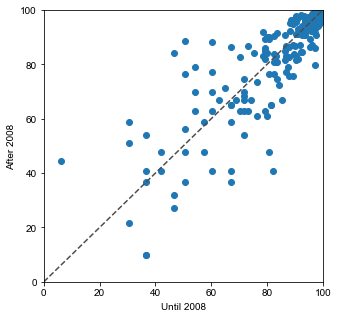

In [17]:
plt.figure(figsize=(5, 5))
plt.plot([0, 100], [0, 100], ls="--", c=".3")
plt.scatter(m['before'], m['now'])


plt.xlabel('Until 2008')
plt.ylabel('After 2008')
plt.xlim(0, 100)
plt.ylim(0, 100)

if save_fig:
    plt.savefig('/Users/tstoeger/Dropbox/ratti/material/tcga_genes.pdf', bbox_inches='tight')

In [18]:
tp.median()

before    50.629258
now       51.102501
found      0.000000
dtype: float64

In [19]:
wilcoxon(tp['before'], tp['now'])

WilcoxonResult(statistic=91860888.0, pvalue=0.4795519102082899)

In [20]:
tp[tp['found']==True].median()

before    92.142077
now       91.772843
found      1.000000
dtype: float64

In [23]:
pd.merge(
    tp[
        (tp['before']<70) &
        (tp['now']>75) &
        (tp['found']==True)
    ].reset_index(),
    df[['Hugo_Symbol', 'Entrez_Gene_Id']].rename(
        columns={'Entrez_Gene_Id': 'gene_ncbi'}).drop_duplicates()).sort_values('now', ascending=False)

,gene_ncbi,before,now,found,Hugo_Symbol
2,23239,50.629258,88.683759,True,PHLPP
5,51592,60.135732,88.111706,True,TRIM33
0,6664,66.974362,86.473556,True,SOX11
6,386653,46.502678,84.182745,True,IL31
4,26038,54.199386,78.919861,True,CHD5
1,10752,60.135732,77.362317,True,CHL1
3,23321,50.629258,76.504238,True,TRIM2
